In [ ]:
!if [ ! -d "ice" ]; then git clone https://github.com/prclibo/ice -b ice; fi
!if [ ! -d "cache" ]; then mkdir cache; fi
!pip install ninja torch==1.8 torchvision==0.9 gdown==4.1
!gdown https://drive.google.com/drive/folders/1P4K2Hl5RZKsJtBTC4AdfiKOG8GPAyzcZ?usp=sharing -O cache --folder
import sys
sys.path.append('ice')
sys.path.append('ice/ice')

In [ ]:
import sys
import itertools
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm

from training.networks import Generator
from wrapper import *

from external.attribution import resnet
import legacy

In [ ]:
# load networks
device = torch.device('cuda')

# We did not find publicly available pre-trained model for face attribution, and train our own using the code of https://github.com/d-li14/face-attribute-prediction
classifier_path = '/your/own/path/face-attribute-prediction/checkpoints/model_best.pth.tar'

# Download from https://github.com/NVlabs/stylegan2
generator_path = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'

truncation_psi = 1
noise_mode = 'const'

with dnnlib.util.open_url(generator_path) as f:
    official_gan = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
gan = Generator(z_dim=official_gan.z_dim,
        c_dim=official_gan.c_dim,
        w_dim=official_gan.w_dim,
        img_resolution=official_gan.img_resolution,
        img_channels=official_gan.img_channels)
gan.load_state_dict(official_gan.state_dict())
gan = gan.to(device)
gan.eval()

attributes = '5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young'.split(' ')
classifier = resnet.resnet50(False)
state_dict = torch.load(classifier_path)['state_dict']
state_dict = {k.replace('module.', ''): v for (k, v) in state_dict.items()}
classifier.load_state_dict(state_dict)
classifier = classifier.to(device)
classifier.eval()

transform = transforms.Compose([
    transforms.Resize(218),
    transforms.CenterCrop([218, 178]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.54it/s]


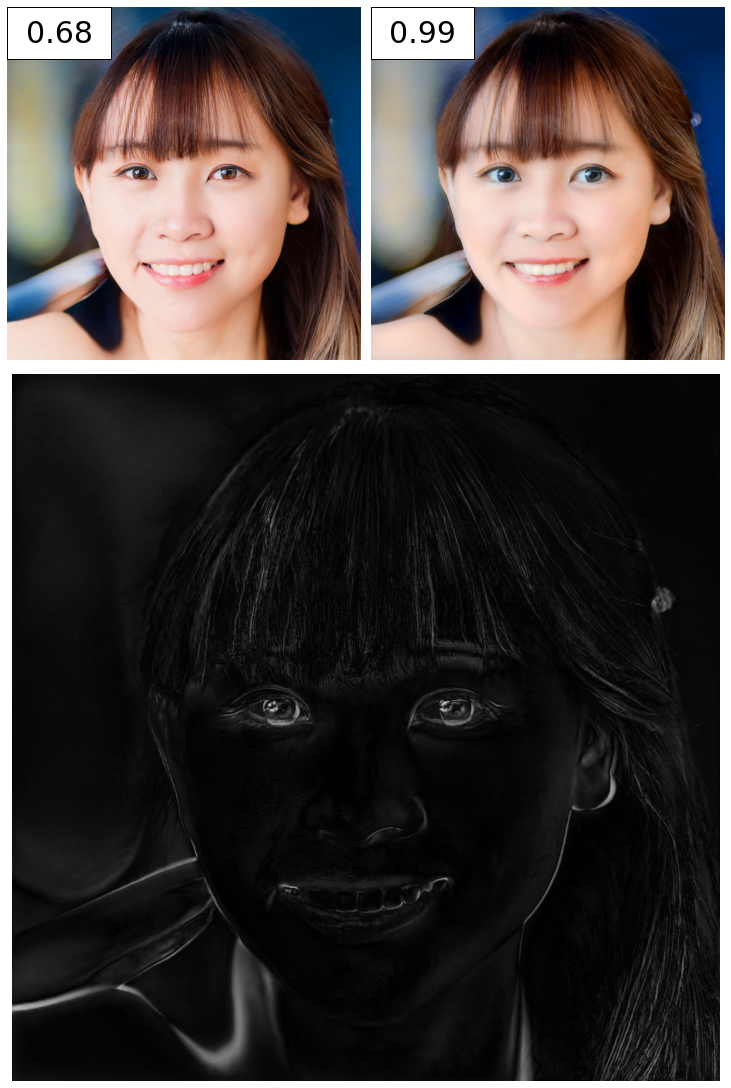

In [ ]:
# optimization on subspaces
batch_size = 1
attribute = "Attractive"  # [Attractive, Smiling, Heavy_Makeup, Pale_Skin]
subspace = "eye_shape" # ["eye_shape", "eye_photometry", "face_color"， "hair_photometry", "lip_color", "mouth_shape", "face_boundary"]

seed = 5
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
n_samples = 500
sample_id = 102 # [78, 102, 218, 325]

# We have to do this ugly loop to replicate the random samples in our paper
with torch.no_grad():
    for i in range(n_samples):
        z0 = torch.randn(1, gan.z_dim, device=device)
        if i == sample_id:
            break
    ws = gan.mapping(z0, None, truncation_psi=truncation_psi)
    styles = gan.compute_styles(ws)
    img = gan.synthesis(styles, noise_mode=noise_mode) * 0.5 + 0.5
    gan.styles = styles
    s = gan.pack_styles(styles)

try: 
    if subspace == "eye_shape":
        iterations = 20
        bases = torch.load('./cache/span_s.eye_boundary_act_fl_sup_mp.pth')
    if subspace == "eye_photometry":
        iterations = 10
        bases = torch.load('./cache/span_s.eye_photo_act_mp_sup_mp.pth')
    if subspace == "face_color":
        iterations = 50
        bases = torch.load('./cache/span_s.face_color_act_mp_sup_mp.pth')
    if subspace == "hair_photometry":
        iterations = 20
        bases = torch.load('./cache/span_s.hair_photom_act_mp_sup_mp.pth')
    if subspace == "lip_color":
        iterations = 20
        bases = torch.load('./cache/span_s.lip_photo_s_act_mp_sup_mp.pth')
    if subspace == "mouth_shape":
        iterations = 20
        bases = torch.load('./cache/span_s.mouth_shape_act_fl_sup_fl_bp.pth')
    if subspace == "face_boundary":
        iterations = 50
        bases = torch.load("./cache/span_s.face_boundary_act_fl_sup_fl_bp.pth")
except:
    raise RuntimeError('Fail to load bases of {} subspace, please generate them using discover_subspaces.ipynb'.format(subspace))

mask = bases[0].abs() > bases[0][0].abs().max() * 1e-2
keep_n_bases = int(torch.sum(mask.float()))
bases = bases[1].T
bases = bases[0:keep_n_bases, :]
bases = bases.cuda()

lambda_s = nn.Parameter(torch.zeros(1, keep_n_bases, device=s.device), requires_grad=True)
optimizer = torch.optim.SGD([lambda_s], lr=1.0, momentum=0.9, weight_decay=1e-3)
criterion = nn.BCELoss()

for i in tqdm(range(iterations)):
    gan.zero_grad()
    classifier.zero_grad()
    optimizer.zero_grad()

    s_ = s + lambda_s @ bases
    styles_ = gan.unpack_styles(s_)
    img_ = gan.synthesis(styles_, noise_mode=noise_mode) * 0.5 + 0.5
    img_trans = transform(img_)
    logits = classifier(img_trans)
    logits = {k: v for k, v in zip(attributes, logits)}
    logit = logits[attribute]
    prob = F.softmax(logit, dim=1)
    if i == 0:
        prob_0 = prob
    loss = logit[0, 0] - logit[0, 1]
#     print(prob, loss)
    loss.backward()
    optimizer.step()

abs_diff = torch.norm(img - img_, dim=1, p=1, keepdim=True).repeat(1, 3, 1, 1)
abs_diff = abs_diff / abs_diff.max()
prob1 = str(round(float(prob_0.data[0, 1]), 2))
prob2 = str(round(float(prob.data[0, 1]), 2))

fig1 = plt.figure(figsize=(10, 15), constrained_layout=True)
widths = [1, 1]
heights = [1, 1, 1]
spec = fig1.add_gridspec(ncols=2, nrows=3, hspace=0, wspace=0, width_ratios=widths, height_ratios=heights)
ax1 = fig1.add_subplot(spec[0, 0])
ax2 = fig1.add_subplot(spec[0, 1])
ax3 = fig1.add_subplot(spec[1:, :])

ax1.imshow(img[0].clamp(0, 1).permute(1, 2, 0).cpu().detach()); ax1.axis('off')
ax2.imshow(img_[0].clamp(0, 1).permute(1, 2, 0).cpu().detach()); ax2.axis('off')
ax3.imshow(abs_diff[0].permute(1, 2, 0).cpu().detach()); ax3.axis('off')
rect1 = plt.Rectangle((0, 0), 300, 150, fill=True, edgecolor="black", facecolor="white", linewidth=1.0)
rect2 = plt.Rectangle((0, 0), 300, 150, fill=True, edgecolor="black", facecolor="white", linewidth=1.0)
ax1.add_patch(rect1)
ax2.add_patch(rect2)
ax1.text(150, 80, prob1, horizontalalignment='center', verticalalignment='center', fontsize=30)
ax2.text(150, 80, prob2, horizontalalignment='center', verticalalignment='center', fontsize=30)
plt.show()